# Analysis Of A Real-World Dataset Using The `JointCRep` Algorithm 

In this tutorial, we show how to use the _Probabilistic Generative Models_ (`probinet`) package for analyzing a real-world dataset.

We use the `JointCRep` (**Joint** **C**ommunity and **Re**ci**p**rocity) algorithm {cite}`contisciani2022community`, which is a 
probabilistic generative model designed to perform inference in directed binary networks. This method jointly models pairs of edges by assuming communities and reciprocity as the main mechanisms for tie formation. 

Let's first configure the logger to show the information about the execution of the algorithm.

In [1]:
# Import the logging module
import logging

# Get the root logger and set its level to INFO
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger("matplotlib").setLevel(logging.WARNING) 

## Importing the data

As a first step, we import the data using the `probinet` package. In this tutorial, we analyze a social network that describes friendships between boys in a small high-school. The network is represented as an adjacency matrix, where each row and column corresponds to a node in the network, and each entry in the matrix indicates whether an edge exists between the corresponding pair of nodes. The network is directed, meaning that the adjacency matrix is asymmetric.

In [2]:
from pathlib import Path
from probinet.input.loader import build_adjacency_from_file

# Get the absolute path of the root directory of the project
root_dir = Path.cwd().parent.parent.parent.resolve()

# Define the path to the input folder
in_folder = root_dir / "probinet" / "data" / "input"

# Define the path of the adjacency matrix
adj = Path("highschool_network.dat")

# Define the complete path of the network
network = in_folder / adj

# Flag to treat the network as undirected
undirected = False

# Call the `build_adjacency_from_file` function to load the network data
# The function takes several arguments:
# - network: the path to the data
# - ego: the name of the column that references the node in one extreme of the directed edge
# - alter: the name of the column that references the other node
# - undirected: the flag that signals if the network is undirected
# - force_dense: if set to True, the algorithm is forced to consider a dense adjacency matrix
# - noselfloop : if set to True, the algorithm removes the self-loops
# - binary: the flag that signals if the network is binary
# - header: the row number to use as the column names
graph_data = build_adjacency_from_file(
    network,
    ego="source",
    alter="target",
    undirected=undirected,
    force_dense=False,
    noselfloop=True,
    binary=True,
    header=0,
)

DEBUG:root:Read adjacency file from /home/dtheuerkauf/software-workshop/prob-gen-model-for-nets/pgm/data/input/highschool_data.dat. The shape of the data is (100, 3).
DEBUG:root:Creating the network ...
DEBUG:root:Removing self loops
INFO:root:Number of nodes = 31
INFO:root:Number of layers = 1
INFO:root:Number of edges and average degree in each layer:
INFO:root:E[0] = 100 - <k> = 6.45
INFO:root:Sparsity [0] = 0.104
INFO:root:Reciprocity (networkX) = 0.520
INFO:root:Reciprocity (considering the weights of the edges) = 0.520


The previous call to `import_data` loads the data from the input folder, and returns the 
following:

- `A`: A list with a MultiGraph (or MultiDiGraph if `undirected=False`) NetworkX object
- `B`: The adjacency matrix describing the graph in `A`
- `B_T`: The transpose of the adjacency matrix `B`
- `data_T_vals`: The observed values for the two-edge joint distributions

To get some information about the data, we can call the `print_graph_stat` function from the `input.stats` module.

In [3]:
from probinet.input.stats import print_graph_stat

# Extract the graph list
A = graph_data.graph_list
# Call the `print_graph_stat` function to print the basic
# statistics of the graph in the list `A`.
print_graph_stat(A)

INFO:root:Number of nodes = 31
INFO:root:Number of layers = 1
INFO:root:Number of edges and average degree in each layer:
INFO:root:E[0] = 100 - <k> = 6.45
INFO:root:Sparsity [0] = 0.104
INFO:root:Reciprocity (networkX) = 0.520


## Configurating the model

To configure the `JointCRep` algorithm, we will use a configuration file. This approach allows for easy customization and reuse of settings. Let's start by defining the configuration dictionary:

In [4]:
config_dict = {
    "K": 4,
    "assortative": False,
    "end_file": "_JointCRep",
    "eta0": None,
    "files": "../data/input/theta.npz",
    "fix_communities": False,
    "fix_eta": False,
    "fix_w": False,
    "initialization": 0,
    "out_folder": "outputs/",
    "out_inference": False,
    "rseed": 0,
    "use_approximation": False,
}

We can also change some of the default numerical parameters and stored them into variables.

In [5]:
# Change other parameters that are not part of the configuration file
num_realizations = 50
plot_loglik = False

We can now save the configuration file to the output folder. This step is optional but recommended for future reference.

In [6]:
import yaml

# Define the evaluation folder
out_folder = Path(config_dict["out_folder"])

# Ensure the evaluation folder exists
out_folder.mkdir(parents=True, exist_ok=True)

# Define the path for the evaluation configuration file
output_config_path = config_dict["out_folder"] + "/setting_JointCRep.yaml"

# Open the evaluation configuration file in write mode
with open(output_config_path, "w") as f:
    # Write the contents of the `conf` dictionary to the file
    yaml.dump(config_dict, f)

## Running the model

In this step, we initialize and execute the `JointCRep` model from the `probinet` package. The `fit` function applies the model to the input data using the configuration setting defined earlier. The algorithm iteratively refines its parameters to capture community structures and reciprocity patterns in the network.  The inferred parameters are stored in the variable `parameters_jointcrep`, facilitating further analysis and evaluation.

In [7]:
from probinet.models.jointcrep import JointCRep

# Create an instance of the `JointCRep` class
model = JointCRep(num_realizations=num_realizations, plot_loglik=plot_loglik)

In [8]:
# Import the `time` module
import time

# Import the `numpy` module
import numpy as np

# Set the logger back to INFO
logging.getLogger().setLevel(logging.INFO)

# Get the current time
time_start = time.time()

# Run the `JointCRep` models using the graph_data
parameters_jointcrep = model.fit(graph_data, **config_dict)

# Print the time elapsed since the start of the `JointCRep` algorithm
print(f"\nTime elapsed: {np.round(time.time() - time_start, 2)} seconds.")

DEBUG:root:Fixing random seed to: 0
DEBUG:root:Random number generator seed: 0
DEBUG:root:eta is initialized randomly.
DEBUG:root:u, v and w are initialized randomly.
DEBUG:root:Updating realization 0 ...
DEBUG:root:num. realization = 0 - iterations = 100 - time = 0.60 seconds
DEBUG:root:num. realizations = 0 - Log-likelihood = -177.5559033559421 - iterations = 161 - time = 0.91 seconds - convergence = True
DEBUG:root:Random number generator seed: 2443250962
DEBUG:root:eta is initialized randomly.
DEBUG:root:u, v and w are initialized randomly.
DEBUG:root:Updating realization 1 ...
DEBUG:root:num. realization = 1 - iterations = 100 - time = 0.62 seconds
DEBUG:root:num. realizations = 1 - Log-likelihood = -155.47946858946176 - iterations = 191 - time = 1.41 seconds - convergence = True
DEBUG:root:Random number generator seed: 1499117434
DEBUG:root:eta is initialized randomly.
DEBUG:root:u, v and w are initialized randomly.
DEBUG:root:Updating realization 2 ...
DEBUG:root:num. realizatio


Time elapsed: 152.35 seconds.


## Analyzing the results
Now that the results are obtained and the parameters are estimated, we can visually explore the network by leveraging the obtained information.

### Communities

Here, we utilize the `NetworkX` library to visualize the graph structure and its communities. The following code snippet defines attributes such as node size, colors, and layout to enhance the visual representation. The `node_size` is proportional to the degree of each node, and the `colors` dictionary assigns distinct colors based on nodes' communities. The layout of the nodes is determined using the spring layout algorithm.

In [9]:
import networkx as nx

# Create a graph from the first adjacency matrix in the list A
graph = A[0]

# Define the size of each node in the graph, proportional to its degree
node_size = [graph.degree[i] * 10 for i in list(graph.nodes())]

# Define a dictionary of colors for different communities in the graph
colors = {0: "indianred", 1: "mediumseagreen", 2: "lightskyblue", 3: "sandybrown"}

# Compute the positions of the nodes in the graph using the spring layout algorithm
# The spring layout positions the nodes using a force-directed algorithm,
# where nodes repel each other and edges act like springs.
# The `k` argument adjusts the optimal distance between nodes
# The `iterations` defines the number of iterations to perform
# The `seed` is used for initializing the random number generator
pos = nx.spring_layout(graph, k=0.05, iterations=100, seed=20)

# Define the color of the edges in the graph
edge_color = "darkgrey"

# Define the color of the nodes in the graph
node_color = "#3b8bc2ff"

As a next step, we employ the `normalize_nonzero_membership` function from the `probinet.input.tools` module to normalize the out-going (`u`) and in-coming (`v`) mixed-memberships, to give a probability interpretation. They are then stored in the `thetas` dictionary. Furthermore, the code extracts hard-memberships by identifying the community to which each node predominantly belongs, which are then stored in the `communities` dictionary. 

In [10]:

from probinet.utils.matrix_operations import normalize_nonzero_membership

# Normalize the out-going mixed-memberships from the inferred parameters
u = normalize_nonzero_membership(parameters_jointcrep[0])

# Normalize the in-coming mixed-memberships from the inferred parameters
v = normalize_nonzero_membership(parameters_jointcrep[1])

# Store the normalized mixed-memberships in a dictionary for easy access
thetas = {"u": u, "v": v}

# Extract hard-memberships by identifying the community with
# the highest membership for each node. This is done by finding
# the index of the maximum value along axis 1 (i.e., across each row).
# The result is a dictionary where the keys are `u` and `v`
# (representing out-going and in-coming memberships respectively)
# and the values are arrays of community indices.
communities = {"u": np.argmax(u, axis=1), "v": np.argmax(v, axis=1)}

Let's now visualize these partitions for a more intuitive understanding. The following code 
snippet utilizes the `plot_hard_membership` function from the `probinet.visualization.plot` module
 to generate a visualization of the hard-memberships within the network, offering a clear depiction of how nodes cluster into different communities.

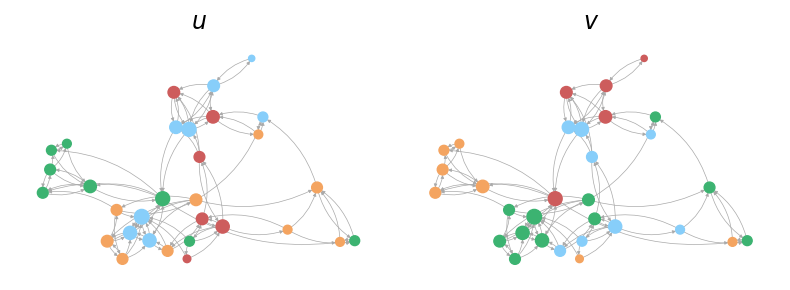

In [11]:
from probinet.visualization.plot import plot_hard_membership

# Call the `plot_hard_membership` function from the `probinet.evaluation.plot` module
# The function takes several arguments:
# - graph: the NetworkX graph object representingthe network
# - communities: the dictionary containing the hard-memberships of nodes
# - pos: the dictionary specifying the positions of nodes in the graph
# - node_size: the list specifying the size of each node; here proportional to
# its degree.
# - colors: the dictionary mapping community indices to colors
# - edge_color: the string specifying the color of the edges in the graph.
_ = plot_hard_membership(graph, communities, pos, node_size, colors, edge_color)

We can also utilize the `plot_soft_membership` function from `probinet.output.plot` to visualize the node mixed-memberships.

In [ ]:
from probinet.visualization.plot import plot_soft_membership

# Call the `plot_soft_membership` function from the `probinet.evaluation.plot` module
_ = plot_soft_membership(graph, thetas, pos, node_size, colors, edge_color)

### Network reconstruction

Now, we assess the performance of the model in network reconstruction tasks. To this end, we can use the marginal and the conditional expected values, as well as the joint distributions, as scores for the estimation of the entries of the adjacency matrix. 

In [13]:
from probinet.evaluation.expectation_computation import (
    compute_marginal_and_conditional_expectation,
)

# Extract the adjacency tensor from the graph data
B = graph_data.adjacency_tensor

# Convert the sparse adjacency matrix `B` to a dense representation
Bdense = B.todense()

# Unpack the latent variables from the results of the `JointCRep` models
# The `u` variable represents the out-going memberships of the
# nodes in the graph.
# The `v` variable represents the in-coming memberships of the
# nodes in the graph.
# The `w` variable represents the affinity of the communities
# The `eta` variable represents the pair-interaction coefficient
# The `maxL` is the maximum log-likelihood achieved during the fitting
u, v, w, eta, maxL = parameters_jointcrep

# Compute the marginal and conditional expected values of the data
# These expected values are based on the inferred parameters and provide a
# measure of the model's fit to the data.
M_marginal, M_conditional = compute_marginal_and_conditional_expectation(
    B=Bdense, U=u, V=v, W=w, eta=eta
)

We plot the adjacency matrices containing marginal and conditional expected values obtained with the inferred parameters. 

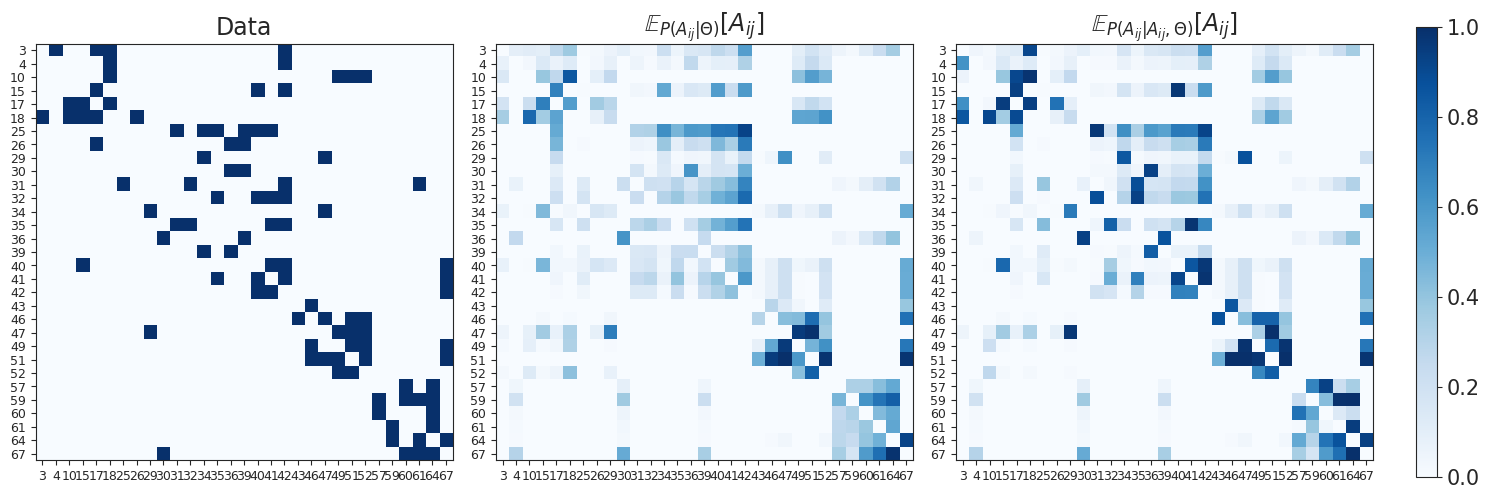

In [14]:
from probinet.visualization.plot import plot_adjacency

# Call the `plot_adjacency` function from the `probinet.evaluation.plot` module
# This function generates a visualization of the adjacency matrix
# of the network, and takes several arguments:
# - Bdense: the dense representation of the adjacency matrix
# - M_marginal: the marginal expected values
# - M_conditional: tje conditional expected values
# - nodes: the list of nodes in the graph
_ = plot_adjacency(Bdense, M_marginal, M_conditional, graph_data.nodes)

Next, we visualize the reconstructed adjacency matrices as graphs. The `plot_graph` function displays the network structure, incorporating information about the marginal and conditional expectations as edge width.

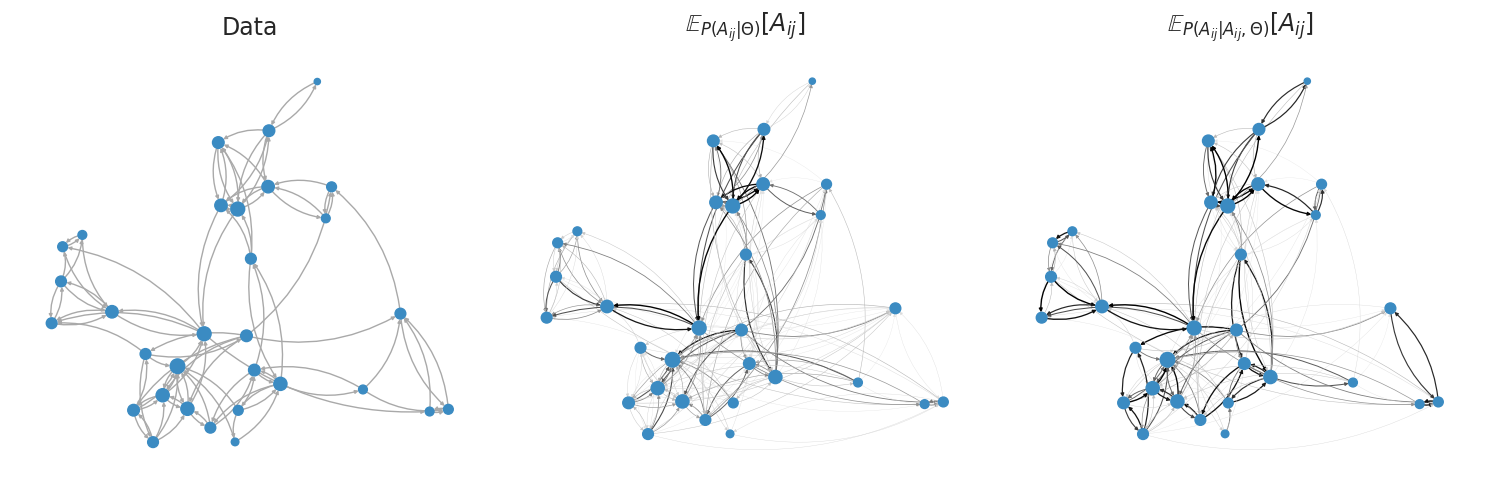

In [47]:
from probinet.visualization.plot import plot_graph

# Call the `plot_graph` function from the `probinet.evaluation.plot` module
_ = plot_graph(graph, M_marginal, M_conditional, pos, node_size, node_color, edge_color)

From the figures, we can notice how the conditional expected values provide a better reconstruction, which is sparser and has more reciprocal edges correctly identified.

In this step, we are going to evaluate how well the network has been reconstructed by 
using joint probabilities. 

In our network, each pair of nodes `(i, j)` can have a connection in both directions, forming a pair `(A(ij), A(ji))`. This pair can have one of four states: `(0, 0)`, `(0, 1)`, `(1, 0)`, or `(1, 1)`. The state `(0, 0)` means there is no edge between nodes `i` and `j` in either direction. The state `(0, 1)` means there is an edge from node `j` to node `i`, but not the other way around. The state `(1, 0)` means there is an edge from node `i` to node `j`, but not the other way around. The state `(1, 1)` means there is an edge in both directions.

We use joint probabilities to predict these states, effectively turning the task of predicting edges in the network into a classification problem. We then compare these predictions with the actual states to assess the quality of the network reconstruction.

In [16]:
from probinet.evaluation.expectation_computation import compute_M_joint

# Compute the joint probability for every pair of edges in the network
# The joint probability is represented as a vector of probabilities
# p=[p00,p01,p10,p11].
p00, p01, p10, p11 = compute_M_joint(U=u, V=v, W=w, eta=eta)

In [17]:
# Define the total number of nodes in the graph
N = len(graph_data.nodes)

# Generate indices for the upper triangular matrix
idx_upper = np.triu_indices(N, k=1)

# Define the possible labels for pairs of edges
inf_labels = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Initialize lists to store the true and predicted labels
true_labels, pred_labels = [], []

# Iterate over each pair of nodes in the upper triangular matrix
for i, j in zip(*idx_upper):
    # Append the true label for the pair of edges to the `true_labels` list
    # The true label is determined by looking up the pair of edge values in
    # the `inf_labels` list.
    true_labels.append(inf_labels.index((int(Bdense[0, i, j]), int(Bdense[0, j, i]))))

    # Compute the probabilities for each possible label for the pair of edges
    # The probabilities are computed based on the joint probabilities
    probs = [p00[0, i, j], p01[0, i, j], p10[0, i, j], p11[0, i, j]]

    # Normalize the probabilities so that they sum to 1
    probs /= sum(probs)

    # Append the predicted label for the pair of edges to the`pred_labels` list
    # The predicted label is the one with the highest probability
    pred_labels.append(np.argmax(probs))

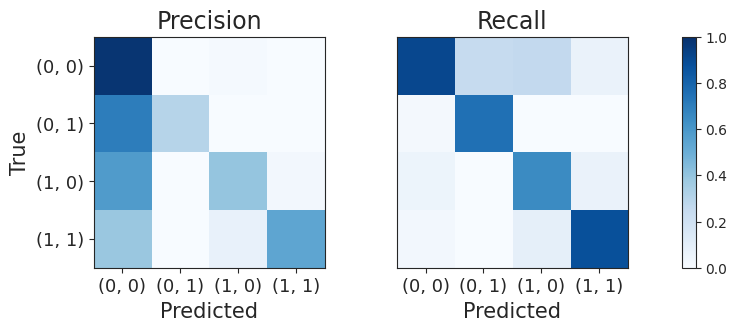

In [18]:
from probinet.visualization.plot import plot_precision_recall
import sklearn

# Compute the confusion matrix between the true and predicted labels
# The confusion matrix is a table that is often used to describe the
# performance of a classification models.
# Each row of the matrix represents the instances in a predicted class,
# while each column represents the instances in an actual class.
# The function `confusion_matrix` from the `sklearn.metrics` module
# is used to compute the confusion matrix.
conf_matrix = sklearn.metrics.confusion_matrix(true_labels, pred_labels)

# Call the `plot_precision_recall` function from the `probinet.evaluation.plot` module
# Precision identifies the proportion of correctly classified observed entries
# Recall (Sensitivity) indicates the proportion of predicted edges
# being correctly classified.
_ = plot_precision_recall(conf_matrix)

The `JointCRep` algorithm is performing well in correctly identifying situations where there are no connections between nodes `(0, 0)` and where there are mutual connections `(1, 1)`. However, when the algorithm makes mistakes, it's usually because it predicts that there are no connections between nodes `(0, 0)`, when in reality there is a one-way connection either from node `i` to node `j` `(1, 0)` or from node `j` to node `i` `(0, 1)`. This suggests that the algorithm has a tendency to predict fewer connections than there actually are, resulting in a network that appears less connected or sparser than the real one.

The recall matrix has the highest entries in the main diagonal, denoting good performance. Overall, in this case, we obtain higher intensities as for the precision, indicating the tendency of labelling the predicted edges with the right type.

### Network sampling

In this section, we examine the performance of `JointCRep` in generating samples that resemble the observed network. In particular, we use the inferred parameters and the observed average degree to generate five synthetic networks by employing the `ReciprocityMMSBM_joints` method. This function reflects the assumptions underlying the `JointCRep` algorithm.

In [19]:
# Create a list of degrees for each node in the graph
degrees = [graph.degree(n) for n in graph.nodes()]

# Calculate the mean degree of the nodes in the graph
# This gives an average measure of connectivity in the network
k = np.mean(degrees)

In [20]:
from probinet.synthetic.reciprocity import ReciprocityMMSBM_joints

# Set the number of communities
K = config_dict["K"]

# Initialize an empty list to store the generated samples
Bsampled = []

# Set the seed for the random number generator to ensure reproducibility
np.random.seed(17)

# Generate a random seed
rseed = np.random.randint(18)

# Generate five samples with different random seeds
for i in range(5):
    # Call the `ReciprocityMMSBM_joints` method from the
    # `probinet.synthetic.syn_sbm` module.
    # The function takes several arguments:
    # - N: the total number of nodes in the graph
    # - K: the number of communities
    # - avg_degree: the desired average degree
    # - show_details: the flag to control the verbosity of the evaluation
    # - show_plots: the flag to plot the sampled networks
    # - eta: the pair-interaction parameter
    # - parameters: the list containing the parameters u, v, and w
    # - seed: the random seed for the models
    # - output_net: the flag to save the sampled networks and the parameters
    syn = ReciprocityMMSBM_joints(
        N=N,
        K=K,
        avg_degree=k,
        show_details=True,
        show_plots=False,
        eta=eta,
        parameters=[u, v, w],
        seed=rseed,
        output_net=False,
    )

    # Append the adjacency matrix of the generated network
    # to the 'Bsampled' list.
    Bsampled.append(syn.layer_graphs[0].toarray())

    # Update the random seed for the next iteration.
    rseed += np.random.randint(1, 18)

INFO:root:Number of nodes = 31
INFO:root:Number of layers = 1
INFO:root:Number of edges and average degree in each layer:
INFO:root:E[0] = 91 - <k> = 5.87
INFO:root:Sparsity [0] = 0.095
INFO:root:Reciprocity (networkX) = 0.462
INFO:root:Number of nodes = 31
INFO:root:Number of layers = 1
INFO:root:Number of edges and average degree in each layer:
INFO:root:E[0] = 98 - <k> = 6.32
INFO:root:Sparsity [0] = 0.102
INFO:root:Reciprocity (networkX) = 0.551
INFO:root:Number of nodes = 30
INFO:root:Number of layers = 1
INFO:root:Number of edges and average degree in each layer:
INFO:root:E[0] = 94 - <k> = 6.27
INFO:root:Sparsity [0] = 0.104
INFO:root:Reciprocity (networkX) = 0.447
INFO:root:Number of nodes = 30
INFO:root:Number of layers = 1
INFO:root:Number of edges and average degree in each layer:
INFO:root:E[0] = 98 - <k> = 6.53
INFO:root:Sparsity [0] = 0.109
INFO:root:Reciprocity (networkX) = 0.551
INFO:root:Number of nodes = 30
INFO:root:Number of layers = 1
INFO:root:Number of edges and 

Let's now visualize the original network's adjacency matrix alongside the five generated samples using the `plot_adjacency_samples` function.

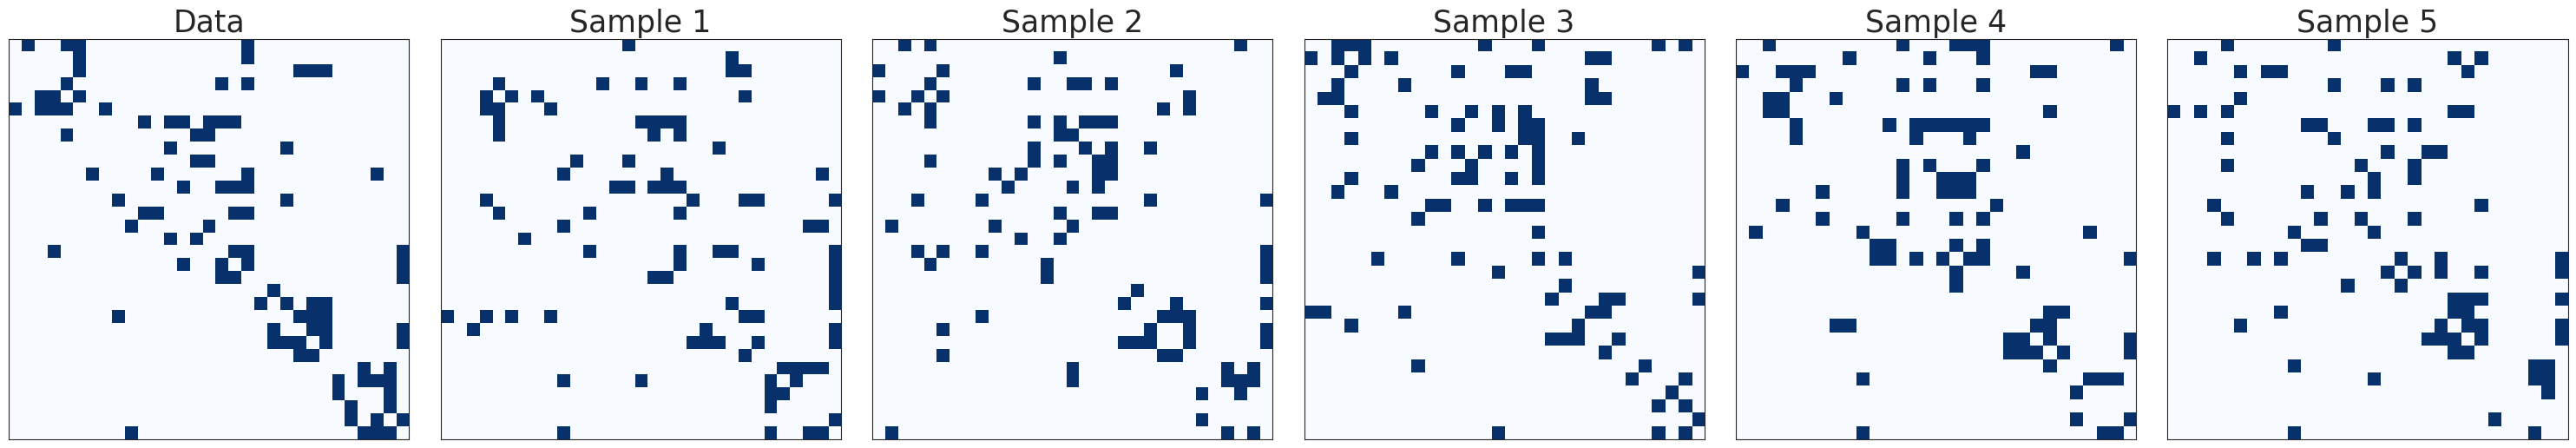

In [21]:
from probinet.visualization.plot import plot_adjacency_samples

# Call the `plot_adjacency_samples` function
# The `Bdense` is the adjacency matrix of the original network
# The `Bsampled` is a list of adjacency matrices of the generated
# samples.
_ = plot_adjacency_samples(Bdense, Bsampled)

The samples seem to resemble the observed network, and we can also notice the dense groups given by reciprocated edges. In addition to these qualitative results, Table D4 in [1] reports the topological properties of the observed data and the sampled networks, showing that `JointCRep` generates networks samples that on average are most similar to the observed data in terms of average degree, reciprocity and clustering coefficient.

For a better understanding of the structure of the package and its configuration, we invite the 
reader to take a look at the tutorial on the [`MTCOV` algorithm](./MTCOV.ipynb). Moreover, to see
 another example on how to use the `synthetic` module, please take a look at the tutorial on 
 [`CRep` algorithm](./CRep.ipynb).

## Summary

This tutorial provides a comprehensive guide on using the Probabilistic Generative Models (`probinet`) package to analyze a real-world network. In particular, it uses the `JointCRep` algorithm, which is a probabilistic generative method designed to perform inference in directed binary networks by jointly modelling pairs of edges and assuming communities and reciprocity as the main mechanisms for tie formation.

The tutorial shows how to import a real-world data using the `probinet` package, how to configure the `JointCRep` algorithm, and how to run it on the input data. 

It also provides different examples for analyzing the results, such as visualizing the nodes' memberships, reconstructing the network with marginal, conditional, and joint distributions, as well as sampling synthetic data that resemble the observed network.
